In [1]:
import pandas as pd
import numpy as np
#import mpl_scatter_density
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import category_encoders as ce
from sklearn.metrics import accuracy_score,classification_report,auc,f1_score,roc_auc_score,roc_curve, confusion_matrix,log_loss
from sklearn.preprocessing import StandardScaler,MinMaxScaler


from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_excel('dataset.xlsx')

In [3]:
df.columns = ['Date','Signal','Speed','Distance','Duration','Result','Type','Time','MOS']

In [4]:
df.shape

(105828, 9)

In [5]:
df['Distance'].fillna(df['Distance'].median(),inplace=True)
df['Signal'].fillna(df['Signal'].median(),inplace=True)
#df.fillna(0,inplace=True)

In [42]:
df = df[df['Speed']!=-1]

df = df[df['Distance']<=72000]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105828 entries, 0 to 105827
Data columns (total 9 columns):
Date        105828 non-null datetime64[ns]
Signal      105828 non-null float64
Speed       105828 non-null float64
Distance    105828 non-null float64
Duration    105828 non-null float64
Result      105828 non-null object
Type        105828 non-null object
Time        105828 non-null float64
MOS         105828 non-null float64
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 7.3+ MB


In [7]:
df.shape

(105828, 9)

In [8]:
df.head()

,Date,Signal,Speed,Distance,Duration,Result,Type,Time,MOS
0,2017-07-01 00:00:27,-61.0,68.800003,1048.60,90.0,SUCCESS,UMTS,0.56,2.1
1,2017-07-01 00:02:57,-61.0,68.769997,1855.54,90.0,SUCCESS,UMTS,0.45,3.2
2,2017-07-01 00:05:29,-71.0,69.169998,1685.62,90.0,SUCCESS,UMTS,0.51,2.1
3,2017-07-01 00:08:02,-65.0,69.279999,1770.92,90.0,SUCCESS,UMTS,0.00,1.0
4,2017-07-01 00:10:30,-103.0,0.820000,256.07,60.0,SUCCESS,UMTS,3.35,3.6


In [49]:
temp_df=df.copy()

In [50]:
for th in [1.0, 2.0, 3.0, 4.0, 5.0]:
     temp_df.loc[(temp_df['MOS']>th - 1)&(temp_df['MOS']<=th),'MOS'] = th

In [51]:
#df.loc[(df['MOS']>th - 1)&(df['MOS']<=th),'MOS'] = th
#temp_df.loc[(temp_df['MOS']>=(th - 0.5))&(temp_df['MOS']<(th+0.5)),'MOS'] = th

In [52]:
temp_df.head()

,Date,Signal,Speed,Distance,Duration,Result,Type,Time,MOS
0,2017-07-01 00:00:27,-61.0,68.800003,1048.60,90.0,SUCCESS,UMTS,0.56,3.0
1,2017-07-01 00:02:57,-61.0,68.769997,1855.54,90.0,SUCCESS,UMTS,0.45,4.0
2,2017-07-01 00:05:29,-71.0,69.169998,1685.62,90.0,SUCCESS,UMTS,0.51,3.0
3,2017-07-01 00:08:02,-65.0,69.279999,1770.92,90.0,SUCCESS,UMTS,0.00,1.0
4,2017-07-01 00:10:30,-103.0,0.820000,256.07,60.0,SUCCESS,UMTS,3.35,4.0


In [53]:
Y = temp_df['MOS']

In [54]:
temp_df.drop(['Date','MOS'],inplace=True,axis=1)

In [55]:
temp_df.head()

,Signal,Speed,Distance,Duration,Result,Type,Time
0,-61.0,68.800003,1048.60,90.0,SUCCESS,UMTS,0.56
1,-61.0,68.769997,1855.54,90.0,SUCCESS,UMTS,0.45
2,-71.0,69.169998,1685.62,90.0,SUCCESS,UMTS,0.51
3,-65.0,69.279999,1770.92,90.0,SUCCESS,UMTS,0.00
4,-103.0,0.820000,256.07,60.0,SUCCESS,UMTS,3.35


In [56]:
from sklearn import decomposition
pca = decomposition.PCA()

In [57]:
X_train, test_df, y_train, y_test = train_test_split(temp_df, Y, stratify=Y, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [58]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 67729
Number of data points in test data: 21166
Number of data points in cross validation data: 16933


In [59]:
y_train.value_counts().sortlevel()

C:\Users\JAYESH\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: sortlevel is deprecated, use sort_index(level=...)
  """Entry point for launching an IPython kernel.


1.0     9707
2.0     2285
3.0    21585
4.0     5185
5.0    28967
Name: MOS, dtype: int64

In [60]:
train_class_distribution = y_train.value_counts().sortlevel()
test_class_distribution = y_test.value_counts().sortlevel()
cv_class_distribution = y_cv.value_counts().sortlevel()

C:\Users\JAYESH\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: sortlevel is deprecated, use sort_index(level=...)
  """Entry point for launching an IPython kernel.
C:\Users\JAYESH\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: sortlevel is deprecated, use sort_index(level=...)
  
C:\Users\JAYESH\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: sortlevel is deprecated, use sort_index(level=...)
  This is separate from the ipykernel package so we can avoid doing imports until


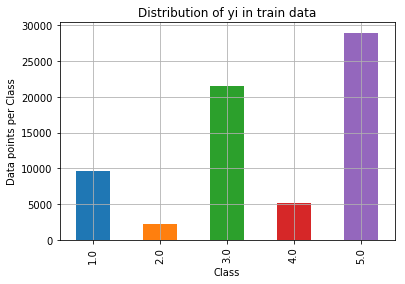

In [61]:
my_colors = 'rgb'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()


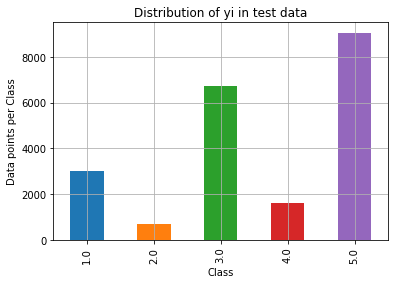

In [62]:
my_colors = 'rgb'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

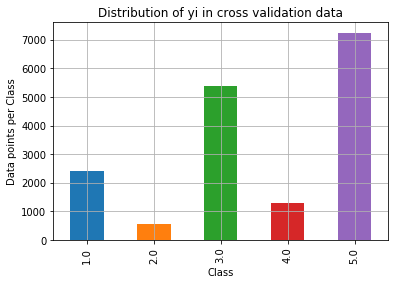

In [63]:
my_colors = 'rgb'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

In [64]:
train_df.head()

,Signal,Speed,Distance,Duration,Result,Type,Time
38605,-65.0,0.00,422.83,90.0,SUCCESS,UMTS,3.92
73701,-115.0,-1.00,885.91,60.0,SUCCESS,LTE,1.50
97341,-53.0,-1.00,546.01,90.0,SUCCESS,UMTS,4.21
46946,-65.0,0.00,979.71,90.0,SUCCESS,UMTS,5.13
20239,-81.0,13.12,1787.33,60.0,SUCCESS,UMTS,3.95


In [65]:
from imblearn.over_sampling import SMOTE

In [66]:
train_df.shape

(67729, 7)

In [67]:
ohe = ce.one_hot.OneHotEncoder(cols=["Result","Type"])
train_df = ohe.fit_transform(train_df)
test_df = ohe.transform(test_df)
cv_df = ohe.transform(cv_df)


In [43]:
sm = SMOTE(sampling_strategy='minority',random_state=42)
train_df, y_train = sm.fit_resample(train_df, y_train)

In [68]:
std_encoder = StandardScaler()
train_df = std_encoder.fit_transform(train_df)
test_df = std_encoder.transform(test_df)
cv_df = std_encoder.transform(cv_df)

C:\Users\JAYESH\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JAYESH\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\JAYESH\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\JAYESH\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [36]:
from sklearn import decomposition
pca = decomposition.PCA()

In [37]:
pca.n_components = 2
pca_data_tr = pca.fit_transform(train_df)
pca_data_cv = pca.transform(cv_df)
pca_data_tst= pca.transform(test_df)
# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced_tr.shape = ", pca_data_tr.shape)
print("shape of pca_reduced_cv.shape = ", pca_data_cv.shape)
print("shape of pca_reduced_tst.shape = ", pca_data_tst.shape)

shape of pca_reduced_tr.shape =  (94411, 2)
shape of pca_reduced_cv.shape =  (16933, 2)
shape of pca_reduced_tst.shape =  (21166, 2)


In [38]:
train_df_final = np.column_stack((train_df,pca_data_tr))

In [39]:
test_df_final = np.column_stack((test_df,pca_data_tst))

In [40]:
cv_df_final = np.column_stack((cv_df,pca_data_cv))

In [35]:
cv_df_final.shape

(16933, 15)

In [46]:
def print_metrix(y_tr,y_prd):
    print("Accuracy:",accuracy_score(y_pred=y_prd,y_true=y_tr))
    print("classfication report:",classification_report(y_pred=y_prd,y_true=y_tr))

In [47]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [38]:
from sklearn.ensemble import RandomForestClassifier

C:\Users\JAYESH\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.579467069828971
classfication report:               precision    recall  f1-score   support

         1.0       0.29      0.24      0.26      3033
         2.0       0.13      0.42      0.20       714
         3.0       0.54      0.58      0.56      6745
         4.0       0.29      0.17      0.22      1621
         5.0       0.86      0.78      0.82      9053

   micro avg       0.58      0.58      0.58     21166
   macro avg       0.42      0.44      0.41     21166
weighted avg       0.61      0.58      0.59     21166

-------------------- Confusion matrix --------------------


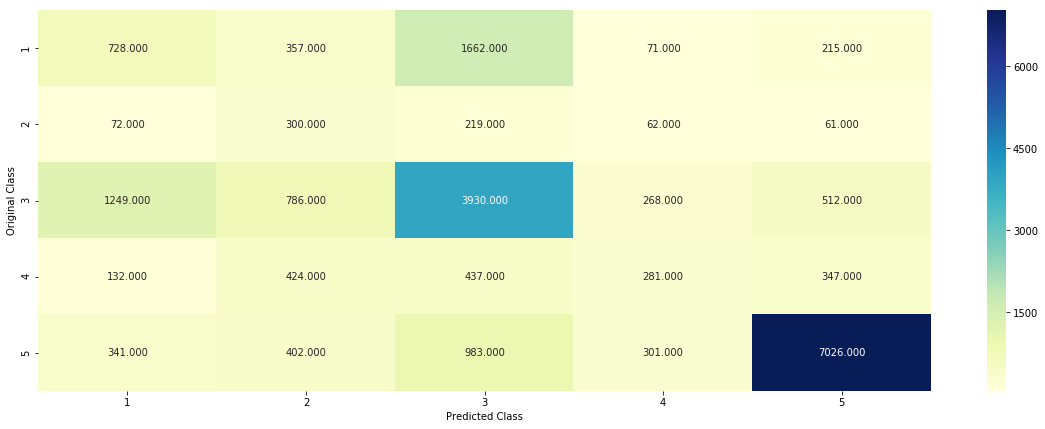

-------------------- Precision matrix (Columm Sum=1) --------------------


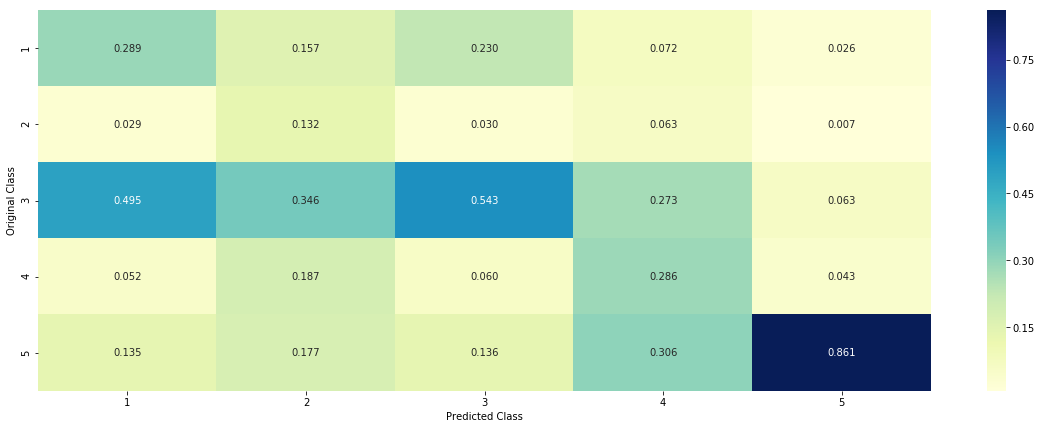

-------------------- Recall matrix (Row sum=1) --------------------


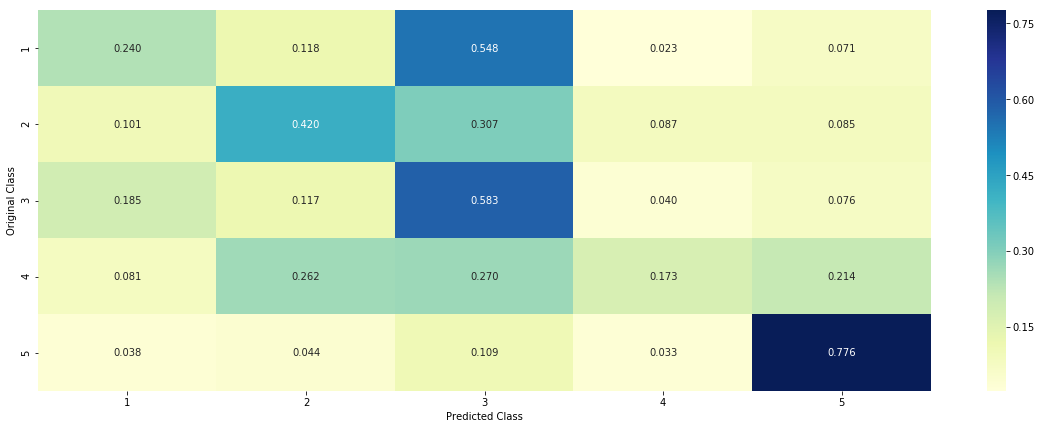

In [40]:
rf = RandomForestClassifier(class_weight='balanced')
rf = rf.fit(train_df_final,y_train)
prd_rf_test = rf.predict(test_df_final)
prd_rf_train = rf.predict(train_df_final)
print_metrix(y_test,prd_rf_test)
plot_confusion_matrix(y_test, prd_rf_test)

In [68]:
np.unique(y_test)

array([1., 2., 3., 4., 5.])

In [50]:
print_metrix(y_train,prd_lgbm_train)

Accuracy: 0.7267161665483894
classfication report:               precision    recall  f1-score   support

         1.0       0.42      0.67      0.52      9707
         2.0       0.98      0.85      0.91     28967
         3.0       0.67      0.55      0.61     21585
         4.0       0.30      0.86      0.44      5185
         5.0       0.99      0.72      0.84     28967

   micro avg       0.73      0.73      0.73     94411
   macro avg       0.67      0.73      0.66     94411
weighted avg       0.82      0.73      0.75     94411



Accuracy: 0.6496267598979495
classfication report:               precision    recall  f1-score   support

         1.0       0.38      0.05      0.08      3033
         2.0       0.72      0.12      0.20       714
         3.0       0.52      0.89      0.66      6745
         4.0       0.36      0.18      0.23      1621
         5.0       0.87      0.80      0.83      9053

   micro avg       0.65      0.65      0.65     21166
   macro avg       0.57      0.41      0.40     21166
weighted avg       0.64      0.65      0.60     21166

-------------------- Confusion matrix --------------------


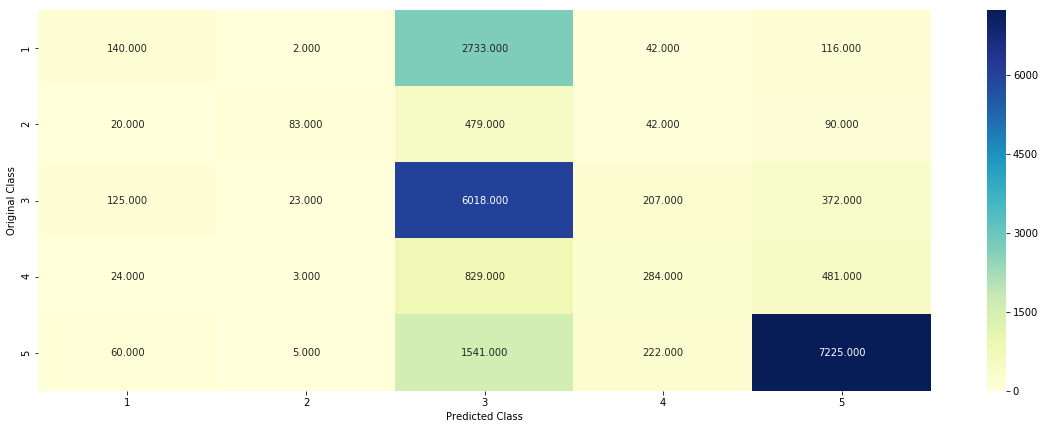

-------------------- Precision matrix (Columm Sum=1) --------------------


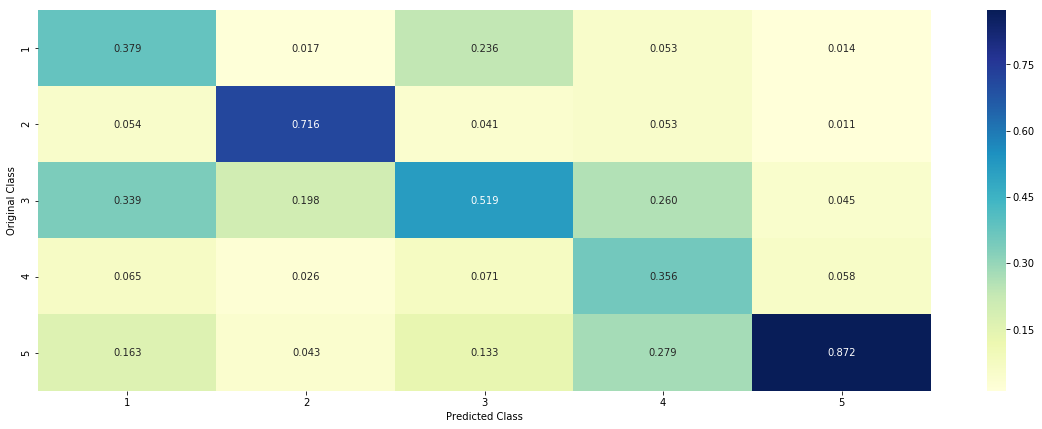

-------------------- Recall matrix (Row sum=1) --------------------


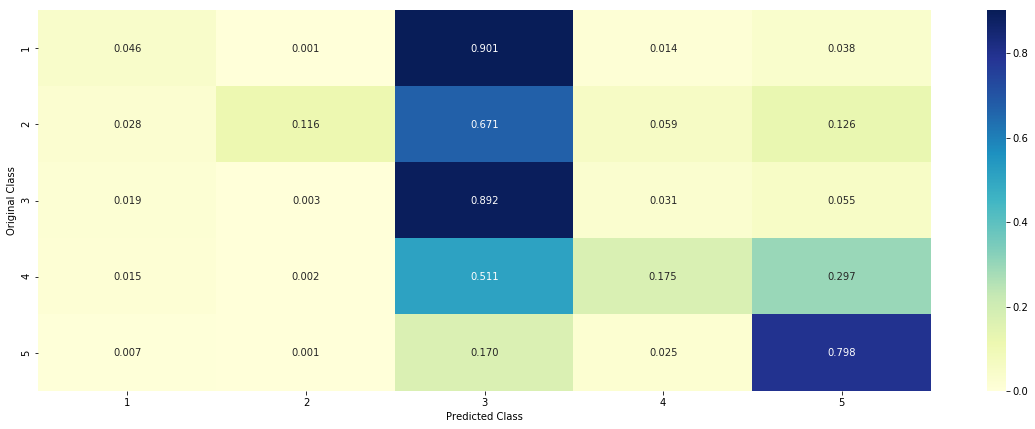

In [69]:
lgbm = LGBMClassifier()
lgbm = lgbm.fit(train_df,y_train)
prd_lgbm_test = lgbm.predict(test_df)
prd_lgbm_train = lgbm.predict(train_df)
print_metrix(y_test,prd_lgbm_test)
plot_confusion_matrix(y_test, prd_lgbm_test)


In [43]:
lgbm = LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.7160783663472557, importance_type='split',
               learning_rate=0.01, max_depth=-1, metric='None',
               min_child_samples=142, min_child_weight=1e-05,
               min_split_gain=0.0, n_estimators=5000, n_jobs=-1, num_leaves=37,
               objective=None, random_state=314, reg_alpha=2, reg_lambda=0.1,
               silent=True, subsample=0.4193485704059235,
               subsample_for_bin=200000, subsample_freq=0)


In [44]:
lgbm = lgbm.fit(train_df_final,y_train)


Accuracy: 0.5825852782764811
classfication report:               precision    recall  f1-score   support

         1.0       0.31      0.48      0.38      3033
         2.0       0.33      0.17      0.22       714
         3.0       0.59      0.47      0.53      6745
         4.0       0.27      0.65      0.38      1621
         5.0       0.98      0.72      0.83      9053

   micro avg       0.58      0.58      0.58     21166
   macro avg       0.49      0.50      0.47     21166
weighted avg       0.68      0.58      0.61     21166

-------------------- Confusion matrix --------------------


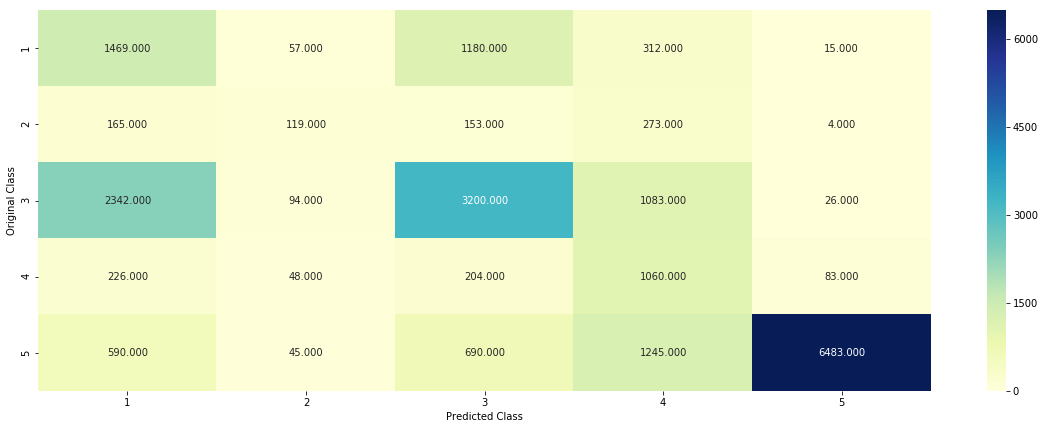

-------------------- Precision matrix (Columm Sum=1) --------------------


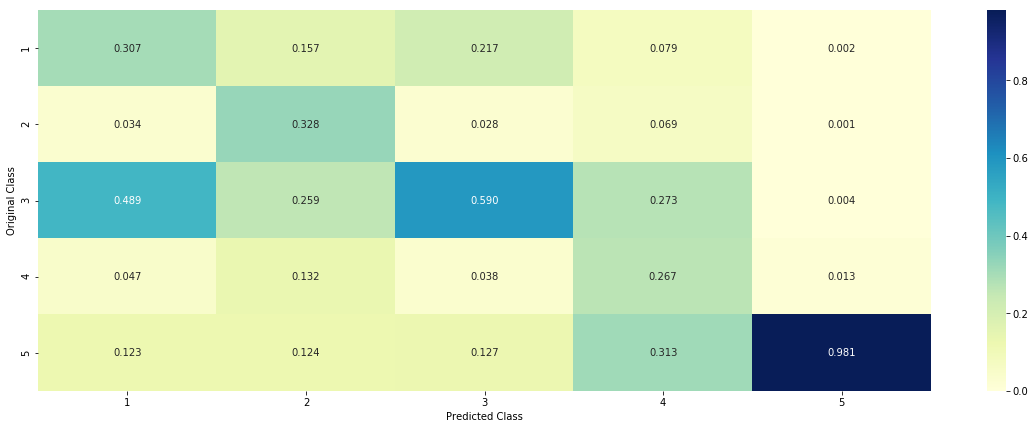

-------------------- Recall matrix (Row sum=1) --------------------


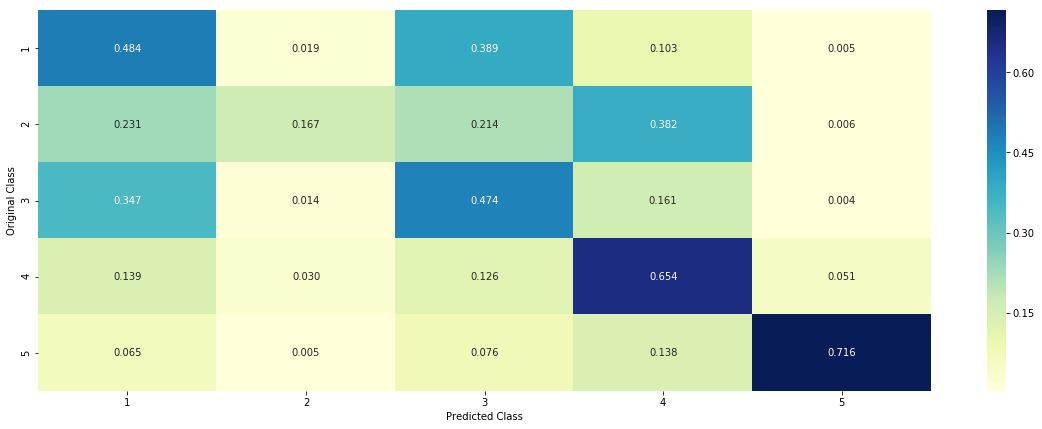

In [49]:
prd_lgbm = lgbm.predict(test_df_final)
prd_lgbm_train = lgbm.predict(train_df_final)
print_metrix(y_test,prd_lgbm)
plot_confusion_matrix(y_test, prd_lgbm)

In [117]:
lgbm.feature_importances_

array([   7,    1,    0,    0,   64,    8,  221,    0, 1337, 1775, 3298,
       1126, 2667, 2105, 2391])

Accuracy: 0.5973639932697701
classfication report:               precision    recall  f1-score   support

         1.0       0.29      0.00      0.01      2643
         2.0       0.12      0.58      0.20       618
         3.0       0.55      0.77      0.64      5942
         4.0       0.41      0.11      0.18      1371
         5.0       0.89      0.77      0.82      7256

   micro avg       0.60      0.60      0.60     17830
   macro avg       0.45      0.45      0.37     17830
weighted avg       0.62      0.60      0.57     17830

-------------------- Confusion matrix --------------------


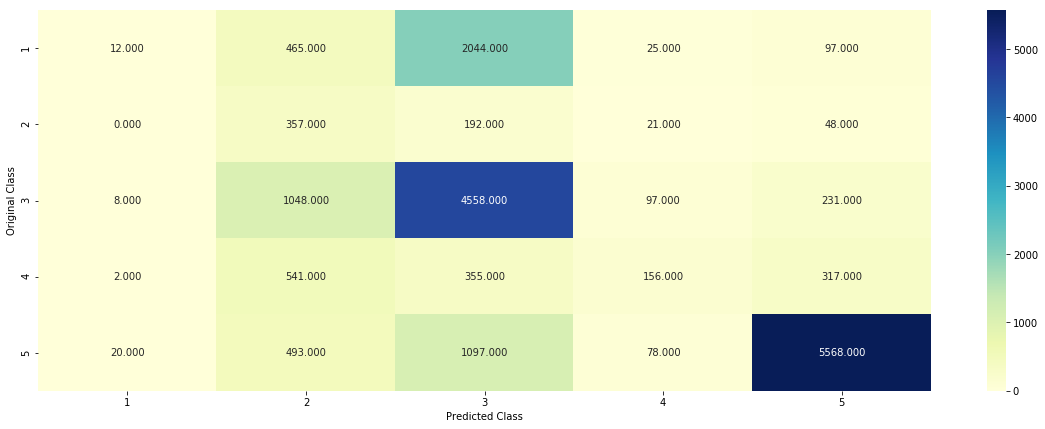

-------------------- Precision matrix (Columm Sum=1) --------------------


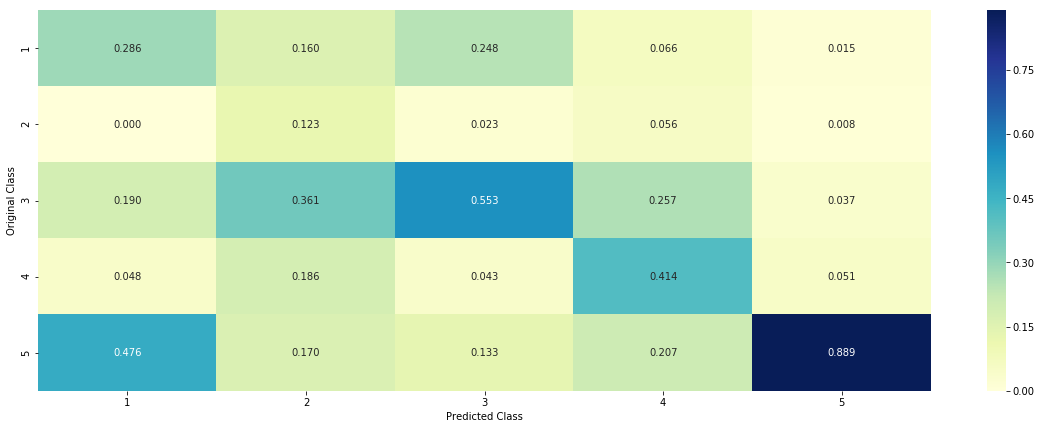

-------------------- Recall matrix (Row sum=1) --------------------


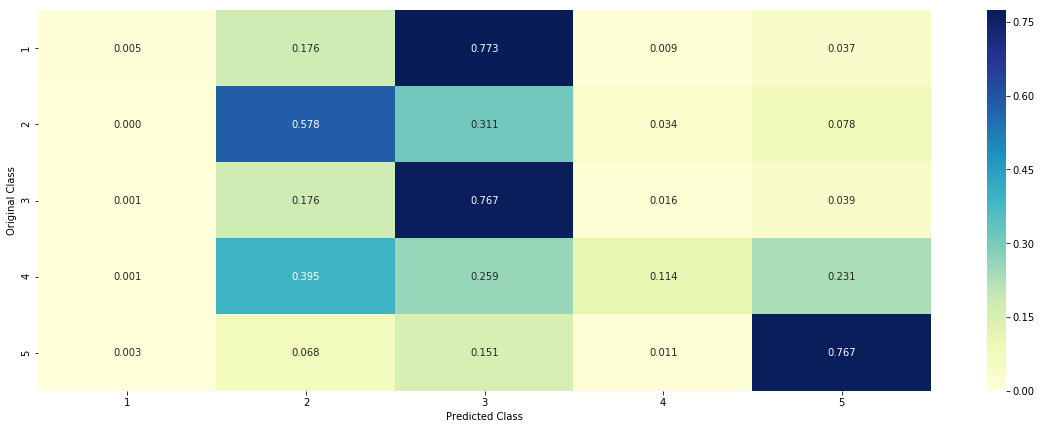

In [51]:
xgb_model = XGBClassifier(learning_rate= 0.002,max_depth= 8,subsample= 0.5,colsample_bytree= 1,objective= 'multi:softmax',seed= 2018)
xgb_model = xgb_model.fit(train_df_final,y_train)
prd_xgb_test = xgb_model.predict(test_df_final)
prd_xgb_train = xgb_model.predict(train_df_final)
print_metrix(y_test,prd_xgb_test)
plot_confusion_matrix(y_test, prd_xgb_test)

In [44]:
from sklearn.neural_network import MLPClassifier

C:\Users\JAYESH\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy: 0.5938867077958497
classfication report:               precision    recall  f1-score   support

         1.0       0.37      0.01      0.01      2643
         2.0       0.12      0.57      0.20       618
         3.0       0.55      0.79      0.65      5942
         4.0       0.31      0.07      0.12      1371
         5.0       0.91      0.75      0.82      7256

   micro avg       0.59      0.59      0.59     17830
   macro avg       0.45      0.44      0.36     17830
weighted avg       0.63      0.59      0.57     17830

-------------------- Confusion matrix --------------------


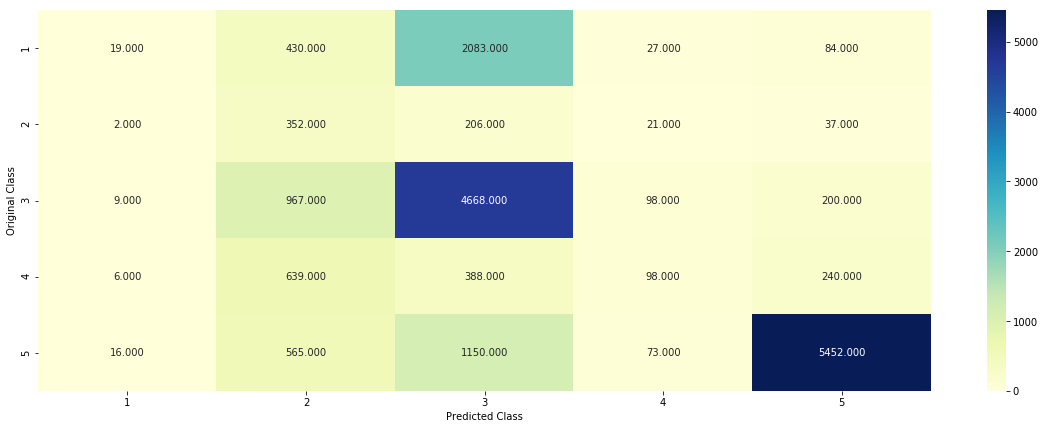

-------------------- Precision matrix (Columm Sum=1) --------------------


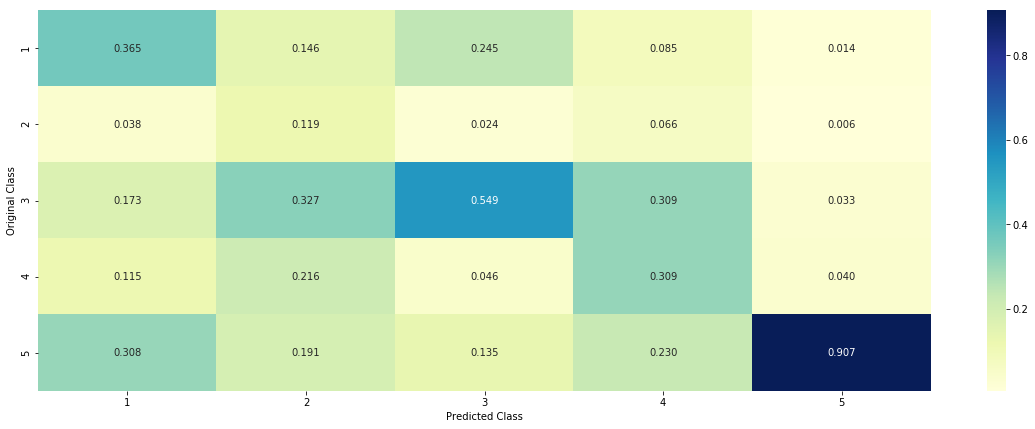

-------------------- Recall matrix (Row sum=1) --------------------


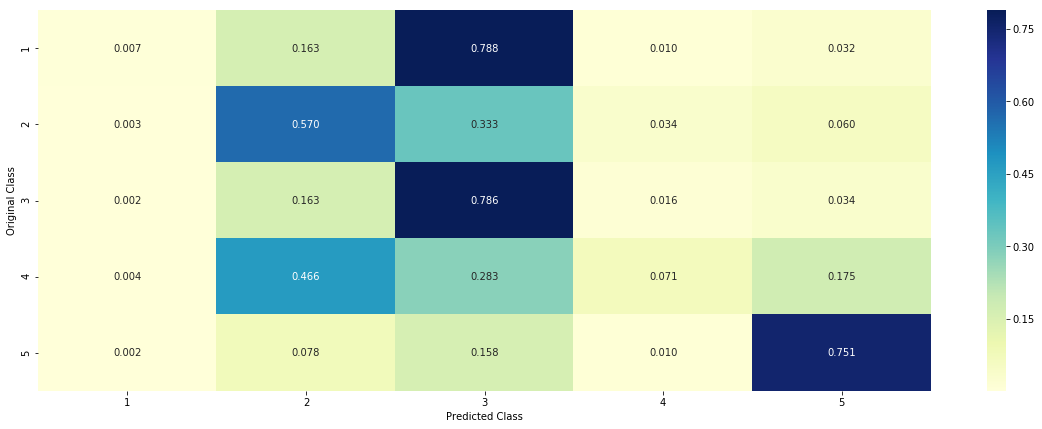

In [52]:
MLP_model = MLPClassifier(hidden_layer_sizes=50)
MLP_model = MLP_model.fit(train_df_final,y_train)
prd_mlp_test = MLP_model.predict(test_df_final)
prd_mlp_train = MLP_model.predict(train_df_final)
print_metrix(y_test,prd_mlp_test)
plot_confusion_matrix(y_test, prd_mlp_test)

In [53]:
ens_train = np.column_stack((prd_lgbm_train,prd_rf_train,prd_xgb_train,prd_mlp_train))

In [54]:
ens_test = np.column_stack((prd_lgbm_test,prd_rf_test,prd_xgb_test,prd_mlp_test))

In [58]:
tmp = np.column_stack((ens_train,y_train))

In [59]:
tmp_df = pd.DataFrame(tmp)

Accuracy: 0.5667975322490185
classfication report:               precision    recall  f1-score   support

         1.0       0.31      0.44      0.36      2643
         2.0       0.42      0.15      0.22       618
         3.0       0.59      0.48      0.53      5942
         4.0       0.26      0.72      0.38      1371
         5.0       0.99      0.69      0.81      7256

   micro avg       0.57      0.57      0.57     17830
   macro avg       0.51      0.50      0.46     17830
weighted avg       0.68      0.57      0.60     17830

-------------------- Confusion matrix --------------------


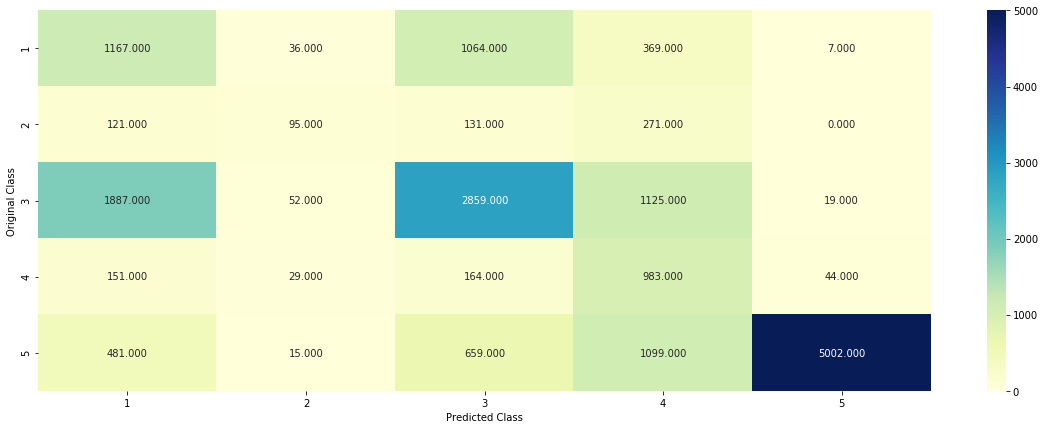

-------------------- Precision matrix (Columm Sum=1) --------------------


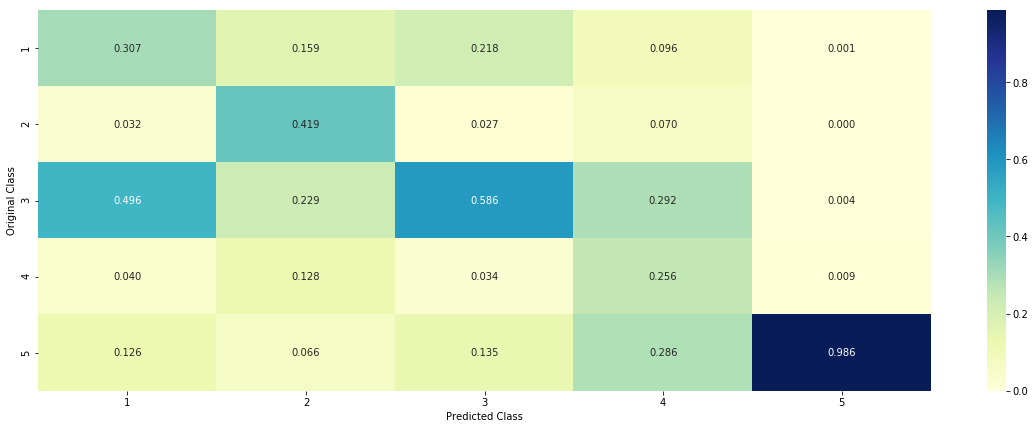

-------------------- Recall matrix (Row sum=1) --------------------


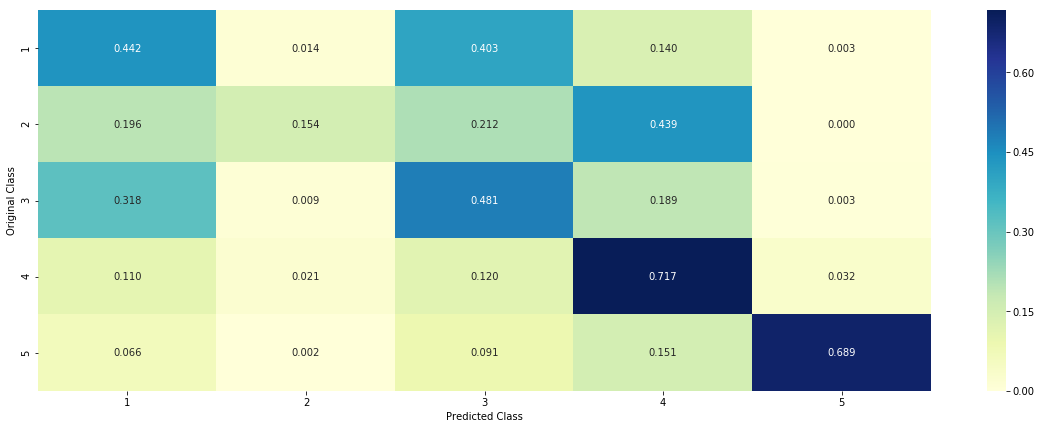

In [55]:
lgbm_final = LGBMClassifier(objective='multiclass',class_weight='balanced')
lgbm_final = lgbm_final.fit(ens_train,y_train)
prd_lgbm_final_test = lgbm_final.predict(ens_test)
prd_lgbm_final_train = lgbm_final.predict(ens_train)
print_metrix(y_test,prd_lgbm_final_test)
plot_confusion_matrix(y_test, prd_lgbm_final_test)

In [62]:
import catboost
from catboost import CatBoostClassifier,Pool

In [63]:
train_pool = Pool(data=train_df,label=y_train)
test_pool = Pool(data=test_df,label = y_test)

In [74]:
from sklearn.utils import class_weight

cls_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

In [75]:
cls_weight

array([1.34929644, 5.76895854, 0.60016831, 2.60168719, 0.49140864])

In [85]:
cb = CatBoostClassifier(class_weights=[0.0,1.34929644, 5.76895854, 0.60016831, 2.60168719, 0.49140864],loss_function='MultiClass',eval_metric='Accuracy')

In [86]:
cb.fit(train_pool,eval_set=test_pool,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4759575	test: 0.4860857	best: 0.4860857 (0)	total: 94.7ms	remaining: 1m 34s
1:	learn: 0.4774689	test: 0.4869296	best: 0.4869296 (1)	total: 182ms	remaining: 1m 30s
2:	learn: 0.4771164	test: 0.4875527	best: 0.4875527 (2)	total: 285ms	remaining: 1m 34s
3:	learn: 0.4772742	test: 0.4866510	best: 0.4875527 (2)	total: 378ms	remaining: 1m 34s
4:	learn: 0.4787138	test: 0.4876044	best: 0.4876044 (4)	total: 471ms	remaining: 1m 33s
5:	learn: 0.4787293	test: 0.4873847	best: 0.4876044 (4)	total: 566ms	remaining: 1m 33s
6:	learn: 0.4823226	test: 0.4922280	best: 0.4922280 (6)	total: 681ms	remaining: 1m 36s
7:	learn: 0.4850243	test: 0.4942764	best: 0.4942764 (7)	total: 777ms	remaining: 1m 36s
8:	learn: 0.4838184	test: 0.4927052	best: 0.4942764 (7)	total: 865ms	remaining: 1m 35s
9:	learn: 0.4843328	test: 0.4883428	best: 0.4942764 (7)	total: 960ms	remaining: 1m 35s
10:	learn: 0.4826383	test: 0.4903970	best: 0.4942764 (7)	total: 1.05s	remaining: 1m 34s
11:	learn: 0.4873378	test: 0.4942921	best

95:	learn: 0.5107227	test: 0.5086813	best: 0.5100583 (68)	total: 11.2s	remaining: 1m 45s
96:	learn: 0.5113370	test: 0.5084906	best: 0.5100583 (68)	total: 11.4s	remaining: 1m 46s
97:	learn: 0.5110482	test: 0.5086487	best: 0.5100583 (68)	total: 11.5s	remaining: 1m 46s
98:	learn: 0.5115104	test: 0.5079418	best: 0.5100583 (68)	total: 11.7s	remaining: 1m 46s
99:	learn: 0.5114699	test: 0.5076687	best: 0.5100583 (68)	total: 11.8s	remaining: 1m 46s
100:	learn: 0.5120020	test: 0.5083504	best: 0.5100583 (68)	total: 12s	remaining: 1m 46s
101:	learn: 0.5123886	test: 0.5085794	best: 0.5100583 (68)	total: 12.2s	remaining: 1m 47s
102:	learn: 0.5121645	test: 0.5086047	best: 0.5100583 (68)	total: 12.3s	remaining: 1m 47s
103:	learn: 0.5121543	test: 0.5085562	best: 0.5100583 (68)	total: 12.5s	remaining: 1m 47s
104:	learn: 0.5127982	test: 0.5090088	best: 0.5100583 (68)	total: 12.5s	remaining: 1m 46s
105:	learn: 0.5134167	test: 0.5105562	best: 0.5105562 (105)	total: 12.6s	remaining: 1m 46s
106:	learn: 0.51

188:	learn: 0.5270079	test: 0.5150261	best: 0.5152448 (178)	total: 20.4s	remaining: 1m 27s
189:	learn: 0.5271227	test: 0.5150261	best: 0.5152448 (178)	total: 20.4s	remaining: 1m 27s
190:	learn: 0.5269755	test: 0.5150261	best: 0.5152448 (178)	total: 20.5s	remaining: 1m 27s
191:	learn: 0.5271660	test: 0.5151781	best: 0.5152448 (178)	total: 20.6s	remaining: 1m 26s
192:	learn: 0.5270717	test: 0.5150604	best: 0.5152448 (178)	total: 20.7s	remaining: 1m 26s
193:	learn: 0.5271736	test: 0.5157066	best: 0.5157066 (193)	total: 20.8s	remaining: 1m 26s
194:	learn: 0.5271306	test: 0.5153811	best: 0.5157066 (193)	total: 20.9s	remaining: 1m 26s
195:	learn: 0.5273767	test: 0.5155607	best: 0.5157066 (193)	total: 21s	remaining: 1m 26s
196:	learn: 0.5272851	test: 0.5155180	best: 0.5157066 (193)	total: 21.1s	remaining: 1m 25s
197:	learn: 0.5275577	test: 0.5155943	best: 0.5157066 (193)	total: 21.2s	remaining: 1m 25s
198:	learn: 0.5272627	test: 0.5154933	best: 0.5157066 (193)	total: 21.2s	remaining: 1m 25s
1

281:	learn: 0.5358157	test: 0.5173019	best: 0.5185236 (278)	total: 28.5s	remaining: 1m 12s
282:	learn: 0.5358992	test: 0.5174058	best: 0.5185236 (278)	total: 28.6s	remaining: 1m 12s
283:	learn: 0.5362367	test: 0.5176976	best: 0.5185236 (278)	total: 28.7s	remaining: 1m 12s
284:	learn: 0.5364457	test: 0.5180968	best: 0.5185236 (278)	total: 28.8s	remaining: 1m 12s
285:	learn: 0.5364329	test: 0.5179192	best: 0.5185236 (278)	total: 28.9s	remaining: 1m 12s
286:	learn: 0.5366162	test: 0.5178069	best: 0.5185236 (278)	total: 29s	remaining: 1m 12s
287:	learn: 0.5364258	test: 0.5180285	best: 0.5185236 (278)	total: 29.1s	remaining: 1m 11s
288:	learn: 0.5364245	test: 0.5182793	best: 0.5185236 (278)	total: 29.2s	remaining: 1m 11s
289:	learn: 0.5362367	test: 0.5183887	best: 0.5185236 (278)	total: 29.3s	remaining: 1m 11s
290:	learn: 0.5368121	test: 0.5184149	best: 0.5185236 (278)	total: 29.4s	remaining: 1m 11s
291:	learn: 0.5368997	test: 0.5181700	best: 0.5185236 (278)	total: 29.5s	remaining: 1m 11s
2

372:	learn: 0.5419979	test: 0.5189544	best: 0.5195485 (313)	total: 37.8s	remaining: 1m 3s
373:	learn: 0.5418302	test: 0.5187065	best: 0.5195485 (313)	total: 37.9s	remaining: 1m 3s
374:	learn: 0.5417842	test: 0.5187321	best: 0.5195485 (313)	total: 38s	remaining: 1m 3s
375:	learn: 0.5417981	test: 0.5199209	best: 0.5199209 (375)	total: 38.1s	remaining: 1m 3s
376:	learn: 0.5420491	test: 0.5196118	best: 0.5199209 (375)	total: 38.2s	remaining: 1m 3s
377:	learn: 0.5420702	test: 0.5199016	best: 0.5199209 (375)	total: 38.3s	remaining: 1m 3s
378:	learn: 0.5420097	test: 0.5199100	best: 0.5199209 (375)	total: 38.4s	remaining: 1m 2s
379:	learn: 0.5421350	test: 0.5196874	best: 0.5199209 (375)	total: 38.6s	remaining: 1m 3s
380:	learn: 0.5423280	test: 0.5200110	best: 0.5200110 (380)	total: 38.7s	remaining: 1m 2s
381:	learn: 0.5422191	test: 0.5200783	best: 0.5200783 (381)	total: 38.8s	remaining: 1m 2s
382:	learn: 0.5422927	test: 0.5200363	best: 0.5200783 (381)	total: 38.9s	remaining: 1m 2s
383:	learn: 

465:	learn: 0.5456579	test: 0.5210487	best: 0.5210487 (464)	total: 46.5s	remaining: 53.3s
466:	learn: 0.5455020	test: 0.5208210	best: 0.5210487 (464)	total: 46.6s	remaining: 53.2s
467:	learn: 0.5456943	test: 0.5211445	best: 0.5211445 (467)	total: 46.7s	remaining: 53.1s
468:	learn: 0.5456132	test: 0.5209028	best: 0.5211445 (467)	total: 46.8s	remaining: 53s
469:	learn: 0.5456254	test: 0.5210487	best: 0.5211445 (467)	total: 46.9s	remaining: 52.9s
470:	learn: 0.5459786	test: 0.5213356	best: 0.5213356 (470)	total: 47s	remaining: 52.8s
471:	learn: 0.5463702	test: 0.5215572	best: 0.5215572 (471)	total: 47.1s	remaining: 52.7s
472:	learn: 0.5463117	test: 0.5214450	best: 0.5215572 (471)	total: 47.2s	remaining: 52.5s
473:	learn: 0.5463104	test: 0.5210907	best: 0.5215572 (471)	total: 47.2s	remaining: 52.4s
474:	learn: 0.5461202	test: 0.5212872	best: 0.5215572 (471)	total: 47.4s	remaining: 52.4s
475:	learn: 0.5463862	test: 0.5213321	best: 0.5215572 (471)	total: 47.6s	remaining: 52.4s
476:	learn: 0.

559:	learn: 0.5500385	test: 0.5198126	best: 0.5215572 (471)	total: 55.2s	remaining: 43.4s
560:	learn: 0.5498024	test: 0.5197004	best: 0.5215572 (471)	total: 55.3s	remaining: 43.3s
561:	learn: 0.5497866	test: 0.5196696	best: 0.5215572 (471)	total: 55.4s	remaining: 43.2s
562:	learn: 0.5498936	test: 0.5193778	best: 0.5215572 (471)	total: 55.5s	remaining: 43.1s
563:	learn: 0.5498512	test: 0.5195574	best: 0.5215572 (471)	total: 55.5s	remaining: 42.9s
564:	learn: 0.5499686	test: 0.5194451	best: 0.5215572 (471)	total: 55.6s	remaining: 42.8s
565:	learn: 0.5499041	test: 0.5197004	best: 0.5215572 (471)	total: 55.7s	remaining: 42.7s
566:	learn: 0.5501960	test: 0.5193348	best: 0.5215572 (471)	total: 55.8s	remaining: 42.6s
567:	learn: 0.5501319	test: 0.5192255	best: 0.5215572 (471)	total: 55.9s	remaining: 42.5s
568:	learn: 0.5502116	test: 0.5194817	best: 0.5215572 (471)	total: 56s	remaining: 42.4s
569:	learn: 0.5500504	test: 0.5194817	best: 0.5215572 (471)	total: 56.1s	remaining: 42.3s
570:	learn: 

652:	learn: 0.5549143	test: 0.5203860	best: 0.5215572 (471)	total: 1m 5s	remaining: 34.9s
653:	learn: 0.5548086	test: 0.5204197	best: 0.5215572 (471)	total: 1m 5s	remaining: 34.8s
654:	learn: 0.5548533	test: 0.5202093	best: 0.5215572 (471)	total: 1m 5s	remaining: 34.7s
655:	learn: 0.5549004	test: 0.5202093	best: 0.5215572 (471)	total: 1m 5s	remaining: 34.6s
656:	learn: 0.5547385	test: 0.5199878	best: 0.5215572 (471)	total: 1m 6s	remaining: 34.5s
657:	learn: 0.5549311	test: 0.5200153	best: 0.5215572 (471)	total: 1m 6s	remaining: 34.3s
658:	learn: 0.5548838	test: 0.5200490	best: 0.5215572 (471)	total: 1m 6s	remaining: 34.2s
659:	learn: 0.5549502	test: 0.5202706	best: 0.5215572 (471)	total: 1m 6s	remaining: 34.1s
660:	learn: 0.5550408	test: 0.5203715	best: 0.5215572 (471)	total: 1m 6s	remaining: 34s
661:	learn: 0.5548129	test: 0.5202256	best: 0.5215572 (471)	total: 1m 6s	remaining: 33.9s
662:	learn: 0.5549791	test: 0.5202256	best: 0.5215572 (471)	total: 1m 6s	remaining: 33.8s
663:	learn: 

744:	learn: 0.5581161	test: 0.5197870	best: 0.5215572 (471)	total: 1m 14s	remaining: 25.6s
745:	learn: 0.5579848	test: 0.5198626	best: 0.5215572 (471)	total: 1m 14s	remaining: 25.5s
746:	learn: 0.5580689	test: 0.5200140	best: 0.5215572 (471)	total: 1m 14s	remaining: 25.4s
747:	learn: 0.5580348	test: 0.5200140	best: 0.5215572 (471)	total: 1m 15s	remaining: 25.3s
748:	learn: 0.5577290	test: 0.5199887	best: 0.5215572 (471)	total: 1m 15s	remaining: 25.2s
749:	learn: 0.5579243	test: 0.5195138	best: 0.5215572 (471)	total: 1m 15s	remaining: 25.2s
750:	learn: 0.5579367	test: 0.5194801	best: 0.5215572 (471)	total: 1m 15s	remaining: 25s
751:	learn: 0.5578052	test: 0.5195558	best: 0.5215572 (471)	total: 1m 15s	remaining: 24.9s
752:	learn: 0.5579667	test: 0.5195558	best: 0.5215572 (471)	total: 1m 15s	remaining: 24.8s
753:	learn: 0.5581856	test: 0.5195978	best: 0.5215572 (471)	total: 1m 15s	remaining: 24.7s
754:	learn: 0.5581415	test: 0.5195221	best: 0.5215572 (471)	total: 1m 15s	remaining: 24.6s
7

836:	learn: 0.5608939	test: 0.5188204	best: 0.5215572 (471)	total: 1m 23s	remaining: 16.3s
837:	learn: 0.5609462	test: 0.5187867	best: 0.5215572 (471)	total: 1m 23s	remaining: 16.2s
838:	learn: 0.5610296	test: 0.5184632	best: 0.5215572 (471)	total: 1m 24s	remaining: 16.1s
839:	learn: 0.5610705	test: 0.5183538	best: 0.5215572 (471)	total: 1m 24s	remaining: 16s
840:	learn: 0.5610810	test: 0.5183875	best: 0.5215572 (471)	total: 1m 24s	remaining: 15.9s
841:	learn: 0.5610909	test: 0.5184968	best: 0.5215572 (471)	total: 1m 24s	remaining: 15.8s
842:	learn: 0.5611733	test: 0.5184212	best: 0.5215572 (471)	total: 1m 24s	remaining: 15.7s
843:	learn: 0.5611894	test: 0.5183538	best: 0.5215572 (471)	total: 1m 24s	remaining: 15.6s
844:	learn: 0.5612914	test: 0.5179190	best: 0.5215572 (471)	total: 1m 24s	remaining: 15.5s
845:	learn: 0.5613502	test: 0.5182217	best: 0.5215572 (471)	total: 1m 24s	remaining: 15.4s
846:	learn: 0.5613843	test: 0.5178879	best: 0.5215572 (471)	total: 1m 24s	remaining: 15.3s
8

927:	learn: 0.5641992	test: 0.5187024	best: 0.5215572 (471)	total: 1m 35s	remaining: 7.42s
928:	learn: 0.5642994	test: 0.5181309	best: 0.5215572 (471)	total: 1m 35s	remaining: 7.32s
929:	learn: 0.5645367	test: 0.5188819	best: 0.5215572 (471)	total: 1m 35s	remaining: 7.21s
930:	learn: 0.5645307	test: 0.5189576	best: 0.5215572 (471)	total: 1m 35s	remaining: 7.11s
931:	learn: 0.5645535	test: 0.5189913	best: 0.5215572 (471)	total: 1m 36s	remaining: 7.01s
932:	learn: 0.5644068	test: 0.5193568	best: 0.5215572 (471)	total: 1m 36s	remaining: 6.9s
933:	learn: 0.5644147	test: 0.5189210	best: 0.5215572 (471)	total: 1m 36s	remaining: 6.8s
934:	learn: 0.5643218	test: 0.5189210	best: 0.5215572 (471)	total: 1m 36s	remaining: 6.69s
935:	learn: 0.5643087	test: 0.5189547	best: 0.5215572 (471)	total: 1m 36s	remaining: 6.59s
936:	learn: 0.5644736	test: 0.5190304	best: 0.5215572 (471)	total: 1m 36s	remaining: 6.48s
937:	learn: 0.5645876	test: 0.5190304	best: 0.5215572 (471)	total: 1m 36s	remaining: 6.38s
9

In [83]:
test_df.shape

(17830, 13)

In [84]:
train_df.shape

(57055, 13)

In [87]:
prd_cb = cb.predict(test_df)
#prd_lgbm_train = lgbm.predict(x_train_enc)
print_metrix(y_test,prd_cb)
plot_confusion_matrix(y_test, prd_cb)

CatboostError: c:/goagent/pipelines/buildmaster/catboost.git/catboost/libs/labels/external_label_helper.cpp:80: Can't convert bad label back to class name.

In [149]:
from sklearn.linear_model import LogisticRegression

C:\Users\JAYESH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.6136256260039686
classfication report:               precision    recall  f1-score   support

         1.0       0.26      0.01      0.02      3033
         2.0       0.23      0.24      0.23       714
         3.0       0.50      0.86      0.64      6745
         4.0       0.26      0.36      0.30      1621
         5.0       0.99      0.70      0.82      9053

   micro avg       0.61      0.61      0.61     21166
   macro avg       0.45      0.44      0.40     21166
weighted avg       0.65      0.61      0.59     21166

-------------------- Confusion matrix --------------------


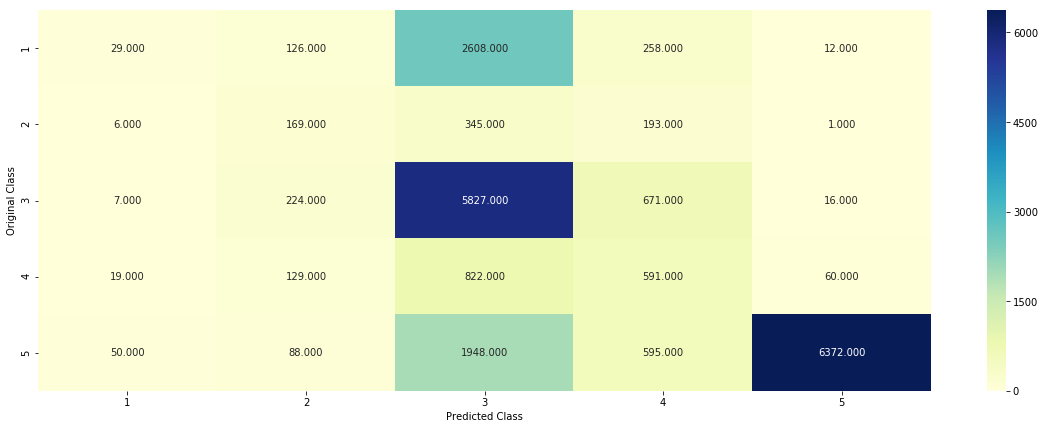

-------------------- Precision matrix (Columm Sum=1) --------------------


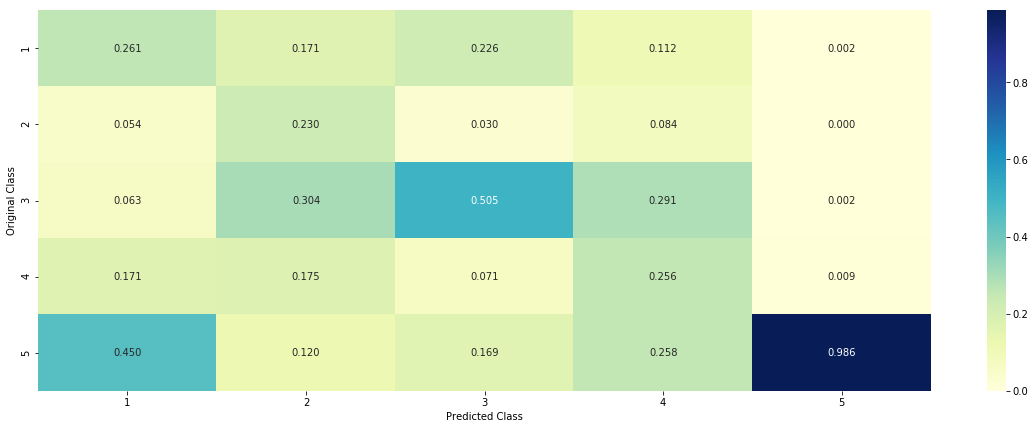

-------------------- Recall matrix (Row sum=1) --------------------


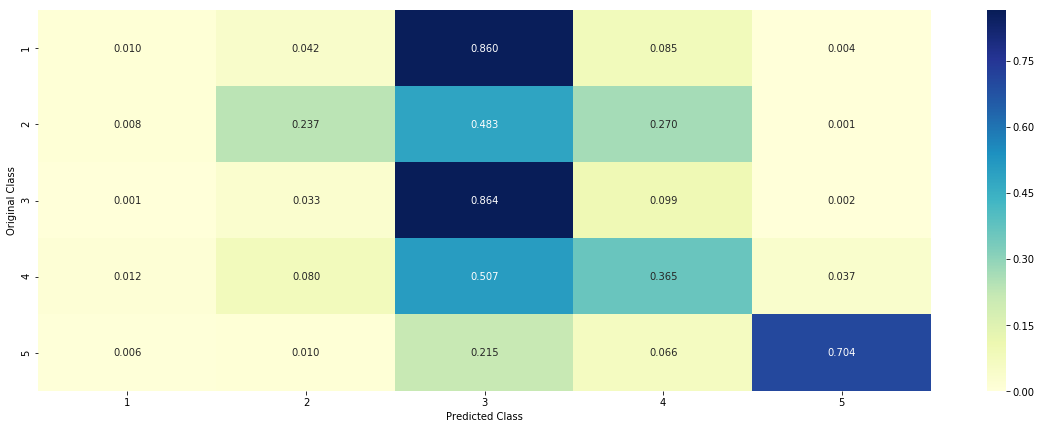

In [228]:
lr = LogisticRegression(multi_class='ovr',class_weight='balanced')
lr = lr.fit(train_df,y_train)
prd_lr = lr.predict(test_df)
#prd_lgbm_train = lgbm.predict(x_train_enc)
print_metrix(y_test,prd_lr)
plot_confusion_matrix(y_test, prd_lr)

In [119]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import pairwise_distances

In [145]:
kmeanModel = MiniBatchKMeans(n_clusters=50,batch_size=10000,random_state=42)
kmeanModel.fit(train_df_final)

MiniBatchKMeans(batch_size=10000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=50,
        n_init=3, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [146]:
train_clusters = kmeanModel.predict(train_df_final)


In [147]:
test_clusters = kmeanModel.predict(test_df_final)

In [156]:
final_train_df = np.column_stack((train_df_final,train_clusters))

In [157]:
final_test_df = np.column_stack((test_df_final,test_clusters))

In [148]:
train_clusters_with_label = np.column_stack((train_clusters,y_train))

In [149]:
train_clusters_with_label = pd.DataFrame(train_clusters_with_label,columns=['cluster','label'])

In [ ]:
sns.catplot(x='label',y='cluster',kind='swarm',data=train_clusters_with_label)

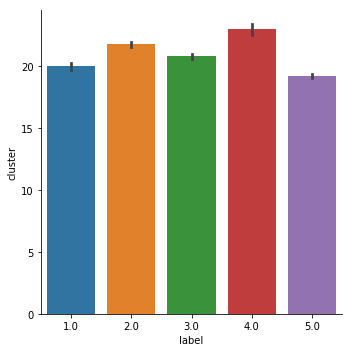

In [155]:
sns.catplot(x='label',y='cluster',kind='bar',data=train_clusters_with_label)

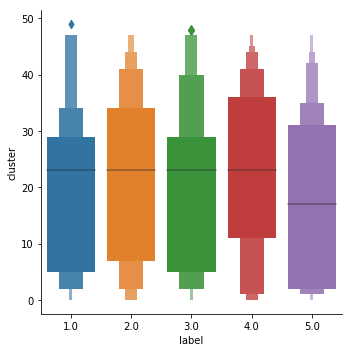

In [153]:
sns.catplot(x='label',y='cluster',kind='boxen',data=train_clusters_with_label)

In [152]:
from keras.utils import np_utils 
from keras.datasets import mnist 
import seaborn as sns
from keras.initializers import RandomNormal
from keras.initializers import he_uniform

from keras.models import Sequential 
from keras.layers import Dense, Activation 

from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout

C:\Users\JAYESH\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [243]:
Y_train = np_utils.to_categorical(y_train, 6) 
Y_test = np_utils.to_categorical(y_test,6)

In [229]:
from imblearn.over_sampling import SMOTE

In [233]:
sm = SMOTE(random_state=42)


In [236]:
train_df_ovs, y_train_ovs = sm.fit_resample(train_df,y_train)

In [237]:
Y_train = np_utils.to_categorical(y_train_ovs, 6)

In [59]:
from sklearn.utils import class_weight

In [60]:
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

In [61]:
class_weight

array([1.34929644, 5.76895854, 0.60016831, 2.60168719, 0.49140864])

In [246]:
output_dim = 6
input_dim = train_df.shape[1]

batch_size = 128 
nb_epoch = 50

In [247]:
model_2_layer= Sequential()
model_2_layer.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_initializer=he_uniform(seed=None)))
model_2_layer.add(Dense(256, activation='relu', kernel_initializer=he_uniform(seed=None)) )
model_2_layer.add(Dropout(0.2))
model_2_layer.add(Dense(105, activation='relu', kernel_initializer=he_uniform(seed=None)) )
model_2_layer.add(Dense(output_dim, activation='softmax'))

print(model_2_layer.summary())

model_2_layer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_2_layer.fit(train_df, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1,class_weight=class_weight, validation_data=(test_df, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               7168      
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 105)               26985     
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 636       
Total params: 166,117
Trainable params: 166,117
Non-trainable params: 0
_________________________________________________________________
None
Train on 67729 samples, validate on 21166 samples
Epoch 1/50
67729/67729 [==============================] - 6s 93us/step - loss: 0.